In [1]:
%env CUDA_VISIBLE_DEVICES = 7

env: CUDA_VISIBLE_DEVICES=7


In [2]:
from warnings import filterwarnings
filterwarnings("ignore")

from feature_analysis3 import *
from processing import *

In [3]:
asset_dictlist = []
for imageset in ['oasis', 'vessel']:
    root = 'images/{}/'.format(imageset)
    assets = glob(root + '*.jpg')
    for asset in assets:
        imgstr = asset.split('/')[-1]
        row = {'image_name': imgstr,
               'image_path': asset,
               'dataset': imageset}
        asset_dictlist.append(row)
image_df = (pd.DataFrame(asset_dictlist)
            .sort_values(by='image_name', ignore_index=True))

In [4]:
response_data = pd.concat([load_response_data(imageset, 'response') for imageset in ['oasis', 'vessel']])
response_data = copy(image_df).merge(response_data, on = 'image_name')

In [5]:
model_string = 'swin_base_patch4_window7_224_imagenet'
model_options = get_model_options()
image_transforms = get_recommended_transforms(model_string)

model_name = model_options[model_string]['model_name']
train_type = model_options[model_string]['train_type']
model_call = model_options[model_string]['call']

In [6]:
model = eval(model_call)
model = model.eval()
if torch.cuda.is_available():
    model = model.cuda()

In [7]:
stimulus_loader = DataLoader(dataset=StimulusSet(image_df.image_path, image_transforms), batch_size=64)

In [8]:
superlative_layers = pd.read_csv('superlative_layers.csv')
superlative_layers['model_string'] = (superlative_layers['model'] + '_' + 
                                      superlative_layers['train_type'])

superlative_layers = superlative_layers.set_index('model_string').to_dict(orient='index')

In [9]:
target_layer = superlative_layers[model_string]['model_layer']

In [10]:
feature_maps = get_all_feature_maps(model, stimulus_loader, numpy=False, layers_to_retain = [target_layer])

Feature Extraction (Batch):   0%|          | 0/23 [00:00<?, ?it/s]

In [11]:
stimulus_features = get_feature_map_srps(feature_maps)

SRP Extraction (Layer):   0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
def cross_ridge_regression(X, train_indices, test_indices, y_ = response_data,
                           train_y='beauty', test_y='beauty', alpha_values=[1000]):

    X_train = X[train_indices]
    y_train = y_[train_indices][train_y]

    X_test = X[test_indices]
    y_test = y_[test_indices][test_y]

    regression = RidgeCV(alphas=alpha_values, store_cv_values=True,
                         scoring='explained_variance').fit(X_train,y_train)

    y_train_pred = regression.cv_values_[:, alpha_values.index(regression.alpha_)]
    
    iid_score = pearson_r_score(y_train, y_train_pred)
    ood_score = pearson_r_score(regression.predict(X_test), y_test)

    return(regression.alpha_, iid_score, ood_score)

In [13]:
X = scale(stimulus_features[target_layer])

train_indices = (response_data['dataset'] == 'vessel')
test_indices = (response_data['dataset'] == 'oasis')

cross_ridge_regression(X, train_indices, test_indices)

(1000, 0.7360344333441466, 0.44716871573812766)

In [14]:
X = scale(stimulus_features[target_layer])

train_indices = (response_data['dataset'] == 'vessel') & (response_data['image_type'] == 'lsc')
test_indices = (response_data['dataset'] == 'oasis') & (response_data['image_type'] == 'Scene')

cross_ridge_regression(X, train_indices, test_indices)

(1000, 0.813600605517861, 0.6143942733518051)

In [15]:
X = scale(stimulus_features[target_layer])

train_indices = (response_data['dataset'] == 'oasis')
test_indices = (response_data['dataset'] == 'oasis')

cross_ridge_regression(X, train_indices, test_indices, train_y = 'beauty', test_y = 'arousal')

(1000, 0.8266300846661037, 0.15129236232728954)

In [46]:
X = scale(stimulus_features[target_layer])

cross_decode_dictlist = []
data_opts = response_data['image_type'].unique().tolist() + ['oasis_combo','vessel_combo']
train_data_iterator = tqdm(data_opts, leave = False)
for train_data in train_data_iterator:
    train_data_iterator.set_description(train_data)
    test_data_iterator = tqdm(data_opts, leave = False)
    for test_data in test_data_iterator:
        test_data_iterator.set_description(test_data)
        if 'combo' in train_data:
            train_indices = (response_data['dataset'] == train_data.split('_')[0])
        if 'combo' in test_data:
            test_indices = (response_data['dataset'] == test_data.split('_')[0])
        if 'combo' not in train_data:
            train_indices = (response_data['image_type'] == train_data)
        if 'combo' not in test_data:
            test_indices = (response_data['image_type'] == test_data)
            
        #print(train_indices.shape, test_indices.shape)
            
        alpha, base_score, cross_score = cross_ridge_regression(X, train_indices, test_indices)
        
        cross_decode_dictlist.append({'model': model_name, 'train_type': train_type, 'model_layer': target_layer,
                                      'train_data': train_data, 'test_data': test_data, 'alpha': alpha,
                                      'base_score': base_score, 'cross_score': cross_score})
        
cross_decoding = pd.DataFrame(cross_decode_dictlist)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

In [31]:
#cross_decoding.to_csv('results/best_layer_beauty_cross_decoding.csv', index = None)

In [54]:
cross_decoding[['train_data','test_data','cross_score']].pivot(index="train_data", columns="test_data", values="cross_score")

test_data,Animal,Object,Person,Scene,are,ari,art,fac,lsc,oasis_combo,vessel_combo
train_data,,,,,,,,,,,
Animal,0.986174,0.406493,0.559320,0.720640,0.166450,-0.005609,0.049897,0.609205,0.381093,0.652249,0.212829
Object,0.518402,0.988891,0.617138,0.808068,0.250486,0.405697,0.052350,0.148205,0.399166,0.744817,0.232695
Person,0.651019,0.455876,0.987254,0.702115,0.141665,0.137648,0.274282,0.705976,0.434822,0.752439,0.273862
Scene,0.491676,0.670205,0.487004,0.993359,0.226191,0.614596,0.434314,0.116917,0.554500,0.716564,0.347797
are,0.040795,0.220634,0.265451,0.292035,0.980039,0.319175,0.333125,-0.003040,0.143724,0.237505,0.347301
ari,-0.105107,0.337730,0.128513,0.476971,0.458433,0.978411,0.151878,0.390237,0.340916,0.288792,0.380727
art,-0.080734,0.032391,0.045138,0.353452,0.196256,0.169667,0.984768,-0.405010,0.268538,0.200777,0.241620
fac,0.109667,0.000198,0.255925,0.164537,-0.154923,0.003815,-0.132768,0.969508,0.198798,0.187801,0.447896
lsc,0.355882,0.356974,0.275999,0.614394,0.077869,0.237083,0.178637,0.324573,0.976922,0.460373,0.471751


In [55]:
cross_decoding.groupby(['train_data'])['cross_score'].mean().sort_values()

train_data
art             0.182442
fac             0.186405
are             0.288795
ari             0.347955
lsc             0.393678
Animal          0.430795
Object          0.469629
Person          0.501542
Scene           0.513920
oasis_combo     0.648102
vessel_combo    0.691852
Name: cross_score, dtype: float64

In [19]:
cross_decoding['cross_score'].mean()

0.4231921734275294

In [20]:
corr_mat = (cross_decoding[['train_data','test_data','cross_score']]
 .pivot(index="train_data", columns="test_data", values="cross_score"))

In [21]:
cat_names = ['Oasis - Animal', 'Oasis - Object', 'Oasis - Person', 'Oasis - Scene', 'Vessel - Indoor', 'Vessel - Outdoor', 
             'Vessel - Art', 'Vessel - Faces', 'Vessel - Scene', 'Oasis - Combo', 'Vessel - Combo']

In [22]:
corr_mat.index.name = None
corr_mat.columns.name = None

corr_mat.index = cat_names
corr_mat.columns = cat_names

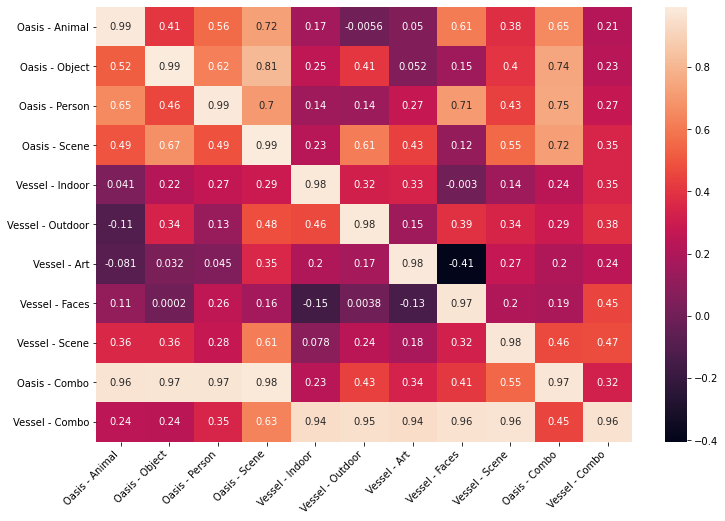

In [23]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(corr_mat, annot=True, ax = ax);
ax.set_xticklabels(labels = cat_names, rotation=45, horizontalalignment='right');

In [56]:
data_opts = [opt for opt in response_data['image_type'].unique().tolist() + ['oasis_combo'] 
                         if opt in ['Scene','Animal','Object','Person','oasis_combo']]

X = scale(stimulus_features[target_layer])

cross_decode_dictlist = []

train_data_iterator = tqdm(data_opts, leave = False)
for train_data in train_data_iterator:
    train_data_iterator.set_description(train_data)
    test_data_iterator = tqdm(data_opts, leave = False)
    for test_data in test_data_iterator:
        test_data_iterator.set_description(test_data)
        if 'combo' in train_data:
            train_indices = (response_data['dataset'] == train_data.split('_')[0])
        if 'combo' in test_data:
            test_indices = (response_data['dataset'] == test_data.split('_')[0])
        if 'combo' not in train_data:
            train_indices = (response_data['image_type'] == train_data)
        if 'combo' not in test_data:
            test_indices = (response_data['image_type'] == test_data)

        for train_affect in ['beauty','arousal', 'valence']:
            for test_affect in ['beauty','arousal', 'valence']:

                alpha, base_score, cross_score = cross_ridge_regression(X, train_indices, test_indices,
                                                                        train_y = train_affect,
                                                                        test_y = test_affect)

                cross_decode_dictlist.append({'model': model_name, 'train_type': train_type, 
                                              'model_layer': target_layer, 'alpha': alpha,
                                              'train_data': train_data, 'test_data': test_data,
                                              'train_y': train_affect, 'test_y': test_affect,
                                              'train': train_data + '_' + train_affect,
                                              'test': test_data + '_' + test_affect,
                                              'base_score': base_score, 'cross_score': cross_score})

affect_cross_decoding = pd.DataFrame(cross_decode_dictlist)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [43]:
affect_cross_decoding

,model,train_type,model_layer,alpha,train_data,test_data,train_y,test_y,train,test,base_score,cross_score
0,swin_base_patch4_window7_224,imagenet,AdaptiveAvgPool1d-1,1000,Object,Object,beauty,beauty,Object_beauty,Object_beauty,0.764642,0.988891
1,swin_base_patch4_window7_224,imagenet,AdaptiveAvgPool1d-1,1000,Object,Object,beauty,arousal,Object_beauty,Object_arousal,0.764642,0.052832
2,swin_base_patch4_window7_224,imagenet,AdaptiveAvgPool1d-1,1000,Object,Object,beauty,valence,Object_beauty,Object_valence,0.764642,0.828428
3,swin_base_patch4_window7_224,imagenet,AdaptiveAvgPool1d-1,1000,Object,Object,arousal,beauty,Object_arousal,Object_beauty,0.789098,0.052724
4,swin_base_patch4_window7_224,imagenet,AdaptiveAvgPool1d-1,1000,Object,Object,arousal,arousal,Object_arousal,Object_arousal,0.789098,0.992377
...,...,...,...,...,...,...,...,...,...,...,...,...
220,swin_base_patch4_window7_224,imagenet,AdaptiveAvgPool1d-1,1000,oasis_combo,oasis_combo,arousal,arousal,oasis_combo_arousal,oasis_combo_arousal,0.749554,0.962744
221,swin_base_patch4_window7_224,imagenet,AdaptiveAvgPool1d-1,1000,oasis_combo,oasis_combo,arousal,valence,oasis_combo_arousal,oasis_combo_valence,0.749554,-0.053769
222,swin_base_patch4_window7_224,imagenet,AdaptiveAvgPool1d-1,1000,oasis_combo,oasis_combo,valence,beauty,oasis_combo_valence,oasis_combo_beauty,0.805164,0.749194
223,swin_base_patch4_window7_224,imagenet,AdaptiveAvgPool1d-1,1000,oasis_combo,oasis_combo,valence,arousal,oasis_combo_valence,oasis_combo_arousal,0.805164,-0.052891


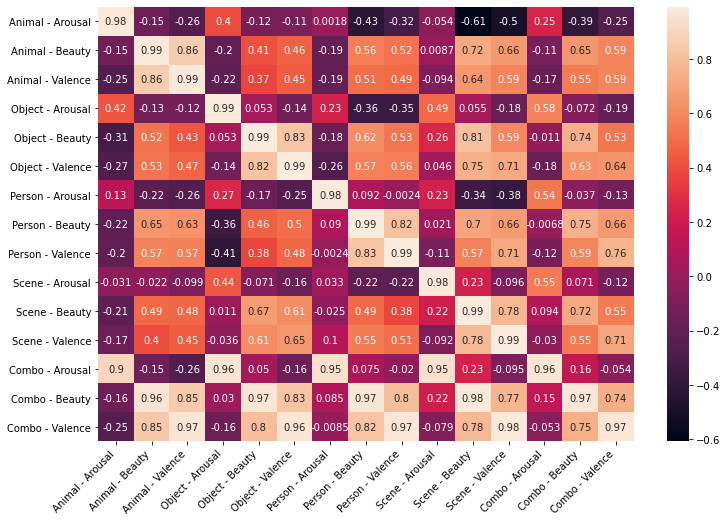

In [44]:
cat_names = ['Animal - Arousal', 'Animal - Beauty', 'Animal - Valence', 
             'Object - Arousal', 'Object - Beauty', 'Object - Valence',
             'Person - Arousal', 'Person - Beauty', 'Person - Valence',
             'Scene - Arousal', 'Scene - Beauty', 'Scene - Valence',
             'Combo - Arousal', 'Combo - Beauty', 'Combo - Valence']

corr_mat = (affect_cross_decoding[['train','test','cross_score']]
            .pivot(index="train", columns="test", values="cross_score"))

corr_mat.index.name = None
corr_mat.columns.name = None

corr_mat.index = cat_names
corr_mat.columns = cat_names

fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(corr_mat, annot=True, ax = ax);
ax.set_xticklabels(labels = cat_names, rotation=45, horizontalalignment='right');

In [30]:
#affect_cross_decoding.to_csv('results/best_layer_affect_cross_decoding.csv', index = None)

### Cross-Decoding across All Layers

In [ ]:
stimulus_features = srp_extraction(model_string, inputs = stimulus_loader)

In [ ]:
data_opts = response_data['image_type'].unique().tolist() + ['oasis_combo','vessel_combo']

cross_decode_dictlist = []
for model_layer_index, model_layer in enumerate(tqdm(stimulus_features)):
    if model_layer_index %1 == 0:
        train_data_iterator = tqdm(data_opts, leave = False)
        X = scale(stimulus_features[model_layer])
        for train_data in train_data_iterator:
            train_data_iterator.set_description(train_data)
            test_data_iterator = tqdm(data_opts, leave = False)
            for test_data in test_data_iterator:
                test_data_iterator.set_description(test_data)
                if 'combo' in train_data:
                    train_indices = (response_data['dataset'] == train_data.split('_')[0])
                if 'combo' in test_data:
                    test_indices = (response_data['dataset'] == test_data.split('_')[0])
                if 'combo' not in train_data:
                    train_indices = (response_data['image_type'] == train_data)
                if 'combo' not in test_data:
                    test_indices = (response_data['image_type'] == test_data)

                #print(train_indices.shape, test_indices.shape)

                alpha, base_score, cross_score = cross_ridge_regression(X, train_indices, test_indices)

                cross_decode_dictlist.append({'model': model_name, 'train_type': train_type, 
                                              'model_layer_index': model_layer_index,
                                              'model_layer': model_layer, 'alpha': alpha,
                                              'train_data': train_data, 'test_data': test_data,
                                              'base_score': base_score, 'cross_score': cross_score})

    category_cross_decoding = pd.DataFrame(cross_decode_dictlist)

In [373]:
#category_cross_decoding.to_csv('results/cross_decoding_scores.csv', index = None)

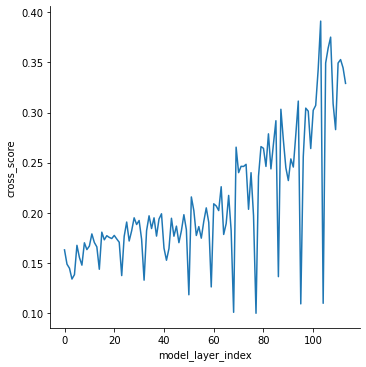

In [33]:
cross_decoding_scores = category_cross_decoding[category_cross_decoding['train_data']!=category_cross_decoding['test_data']]

sns.relplot(data = cross_decoding_scores.groupby(['model_layer','model_layer_index'])['cross_score'].mean().reset_index(),
            x = 'model_layer_index', y = 'cross_score', kind = 'line');

In [336]:
(cross_decoding_scores.groupby(['model','model_layer','model_layer_index'])['cross_score']
 .mean().reset_index().sort_values(by='cross_score'))

,model,model_layer,model_layer_index,cross_score
21,vit_base_patch16_224,Dropout-34,77,0.100185
20,vit_base_patch16_224,Dropout-30,68,0.101164
23,vit_base_patch16_224,Dropout-42,95,0.109543
24,vit_base_patch16_224,Dropout-46,104,0.110109
18,vit_base_patch16_224,Dropout-22,50,0.118619
...,...,...,...,...
105,vit_base_patch16_224,Linear-46,105,0.349259
57,vit_base_patch16_224,LayerNorm-25,111,0.352669
56,vit_base_patch16_224,LayerNorm-24,106,0.364039
106,vit_base_patch16_224,Linear-47,107,0.375021


In [51]:
max_transform(cross_decoding_scores.groupby(['model','model_layer','model_layer_index'])['cross_score']
              .mean().reset_index(), group_vars = ['model'], measure_var = 'cross_score')

,model,model_layer,model_layer_index,cross_score
0,vit_base_patch16_224,Linear-45,103,0.390973


In [ ]:
data_opts = response_data['image_type'].unique().tolist() + ['oasis_combo']
data_opts = [opt for opt in data_opts if opt in ['Scene','Animal','Object','Person','oasis_combo']]

cross_decode_dictlist = []
for model_layer_index, model_layer in enumerate(tqdm(stimulus_features)):
    if model_layer_index %1 == 0:
        train_data_iterator = tqdm(data_opts, leave = False)
        X = scale(stimulus_features[model_layer])
        for train_data in train_data_iterator:
            train_data_iterator.set_description(train_data)
            test_data_iterator = tqdm(data_opts, leave = False)
            for test_data in test_data_iterator:
                test_data_iterator.set_description(test_data)
                if 'combo' in train_data:
                    train_indices = (response_data['dataset'] == train_data.split('_')[0])
                if 'combo' in test_data:
                    test_indices = (response_data['dataset'] == test_data.split('_')[0])
                if 'combo' not in train_data:
                    train_indices = (response_data['image_type'] == train_data)
                if 'combo' not in test_data:
                    test_indices = (response_data['image_type'] == test_data)

                #print(train_indices.shape, test_indices.shape)
                
                for train_affect in ['beauty','arousal', 'valence']:
                    for test_affect in ['beauty','arousal', 'valence']:

                        alpha, base_score, cross_score = cross_ridge_regression(X, train_indices, test_indices,
                                                                                train_y = train_affect,
                                                                                test_y = test_affect)

                        cross_decode_dictlist.append({'model': model_name, 'train_type': train_type, 
                                                      'model_layer_index': model_layer_index,
                                                      'model_layer': model_layer, 'alpha': alpha,
                                                      'train_data': train_data, 'test_data': test_data,
                                                      'train_y': train_affect, 'test_y': test_affect,
                                                      'base_score': base_score, 'cross_score': cross_score})

    affect_cross_decoding = pd.DataFrame(cross_decode_dictlist)
    
affect_cross_decoding['train'] = affect_cross_decoding['train_data'] + '_' + affect_cross_decoding['train_y']
affect_cross_decoding['test'] = affect_cross_decoding['test_data'] + '_' + affect_cross_decoding['test_y']
affect_cross_decoding['cross_score'] = affect_cross_decoding['cross_score'].astype(np.float)

In [374]:
#affect_cross_decoding.to_csv('results/affect_cross_decoding.csv', index = None)